In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
!mkdir models
!mkdir utils
!mv conv_nets.py models
!mv resnet.py models
!mv visualizations.py utils 
!mv train_utils.py utils 

In [12]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl

from models.conv_nets import make_convNet 
from utils.train_utils import train_conv_nets
from utils.visualizations import plot_loss_from_file_convnets, plot_loss_vs_epoch_from_file_convnets


# keeps tensorflow from using all available GPU memory when a model is initialized.
gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [ ]:
convnet_widths = [(i + 1) for i in range(16)] + [16 + 4*(i + 1) for i in range(12)] 
convnet_depth = 5

train_conv_nets(
    data_set='cifar10',
    convnet_depth=convnet_depth,
    convnet_widths=convnet_widths,
    label_noise_as_int=10,
    scaled_loss_alpha=0.9,
    data_save_path_prefix='drive/MyDrive/MDL_Paper_Experiments'
)

STARTING TRAINING: conv_net_depth_5_width_1, Alpha: 0.9
Epoch: 0000, Total Run Time: 00:00:02 - Loss: nan, Accuracy: 0.101, Test Loss: nan, Test Accuracy: 0.100
Epoch: 0025, Total Run Time: 00:00:34 - Loss: nan, Accuracy: 0.101, Test Loss: nan, Test Accuracy: 0.100
Epoch: 0050, Total Run Time: 00:01:06 - Loss: nan, Accuracy: 0.101, Test Loss: nan, Test Accuracy: 0.100
Epoch: 0075, Total Run Time: 00:01:38 - Loss: nan, Accuracy: 0.101, Test Loss: nan, Test Accuracy: 0.100
Epoch: 0100, Total Run Time: 00:02:11 - Loss: nan, Accuracy: 0.101, Test Loss: nan, Test Accuracy: 0.100
Epoch: 0125, Total Run Time: 00:02:43 - Loss: nan, Accuracy: 0.101, Test Loss: nan, Test Accuracy: 0.100
Epoch: 0150, Total Run Time: 00:03:15 - Loss: nan, Accuracy: 0.101, Test Loss: nan, Test Accuracy: 0.100
Epoch: 0175, Total Run Time: 00:03:48 - Loss: nan, Accuracy: 0.101, Test Loss: nan, Test Accuracy: 0.100
Epoch: 0200, Total Run Time: 00:04:21 - Loss: nan, Accuracy: 0.101, Test Loss: nan, Test Accuracy: 0.100

In [ ]:
batch_size=128
n_epochs = 500_000 // (50_000 // 128) # total number desirec SGD steps / number batches per epoch

label_noise_int = 0
label_noise = label_noise_int / 100

# load the Cifar 10 data set
cifar10 = tf.keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
image_shape = x_train[0].shape

# apply label noise to the data set
random_idx = np.random.choice(x_train.shape[0], int(label_noise*x_train.shape[0]))
rand_labels = np.random.randint(low=y_train.min(), high=y_train.max(), size=len(random_idx))
y_train[random_idx] = np.expand_dims(rand_labels, axis=1)

model_histories = {}
convnet_widths = [(i + 1) for i in range(16)] + [16 + 4*(i + 1) for i in range(12)] 
convnet_depth = 5

# Paths to save model weights and 
model_weights_paths = f'trained_model_weights/conv_nets_depth_{convnet_depth}_{label_noise_int}pct_noise/'
data_save_path = 'experimental_results/conv_nets_'

for width in convnet_widths:
    # Depth 5 Conv Net using default Kaiming Uniform Initialization.
    conv_net, model_id = make_convNet(image_shape, depth=convnet_depth, init_channels=width)

    conv_net.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=inverse_squareroot_lr()),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    model_timer = timer()
    
    print(f'STARTING TRAINING: {model_id}')
    history = conv_net.fit(
        x=x_train, y=y_train, 
        validation_data=(x_test, y_test),
        epochs=n_epochs,
        batch_size=batch_size,
        verbose=0, 
        callbacks = [model_timer]
    )
    print(f'FINISHED TRAINING: {model_id}')    
    
    # add results to dictionary and store the resulting model weights.
    model_histories[model_id] = history
    history.model.save_weights(model_weights_paths+model_id)
    
    # clear GPU of prior model to decrease training times.
    tf.keras.backend.clear_session()
    
    
# store all the results in a pickle file for later graphing and analysis.
depth_5_metrics = {} 

for m_id, history in model_histories.items():
    depth_5_metrics[m_id] = history.history
    
pkl.dump(depth_5_metrics, open(data_save_path + f'depth_{convnet_depth}_{label_noise_int}pct_noise.pkl', 'wb'))

STARTING TRAINING: conv_net_depth_5_width_1
Epoch: 0000, Total Run Time: 00:00:11 - Loss: 2.0853e+00, Accuracy: 0.219, Test Loss: 1.9668e+00, Test Accuracy: 0.260
Epoch: 0025, Total Run Time: 00:01:47 - Loss: 1.6138e+00, Accuracy: 0.406, Test Loss: 1.7295e+00, Test Accuracy: 0.368
Epoch: 0050, Total Run Time: 00:03:25 - Loss: 1.5901e+00, Accuracy: 0.419, Test Loss: 1.5992e+00, Test Accuracy: 0.407
Epoch: 0075, Total Run Time: 00:05:00 - Loss: 1.5766e+00, Accuracy: 0.426, Test Loss: 1.6044e+00, Test Accuracy: 0.408
Epoch: 0100, Total Run Time: 00:06:36 - Loss: 1.5636e+00, Accuracy: 0.431, Test Loss: 1.5652e+00, Test Accuracy: 0.423
Epoch: 0125, Total Run Time: 00:08:12 - Loss: 1.5517e+00, Accuracy: 0.439, Test Loss: 1.5870e+00, Test Accuracy: 0.406
Epoch: 0150, Total Run Time: 00:09:47 - Loss: 1.5429e+00, Accuracy: 0.437, Test Loss: 1.6291e+00, Test Accuracy: 0.408
Epoch: 0175, Total Run Time: 00:11:23 - Loss: 1.5384e+00, Accuracy: 0.442, Test Loss: 1.5765e+00, Test Accuracy: 0.422
Epoc

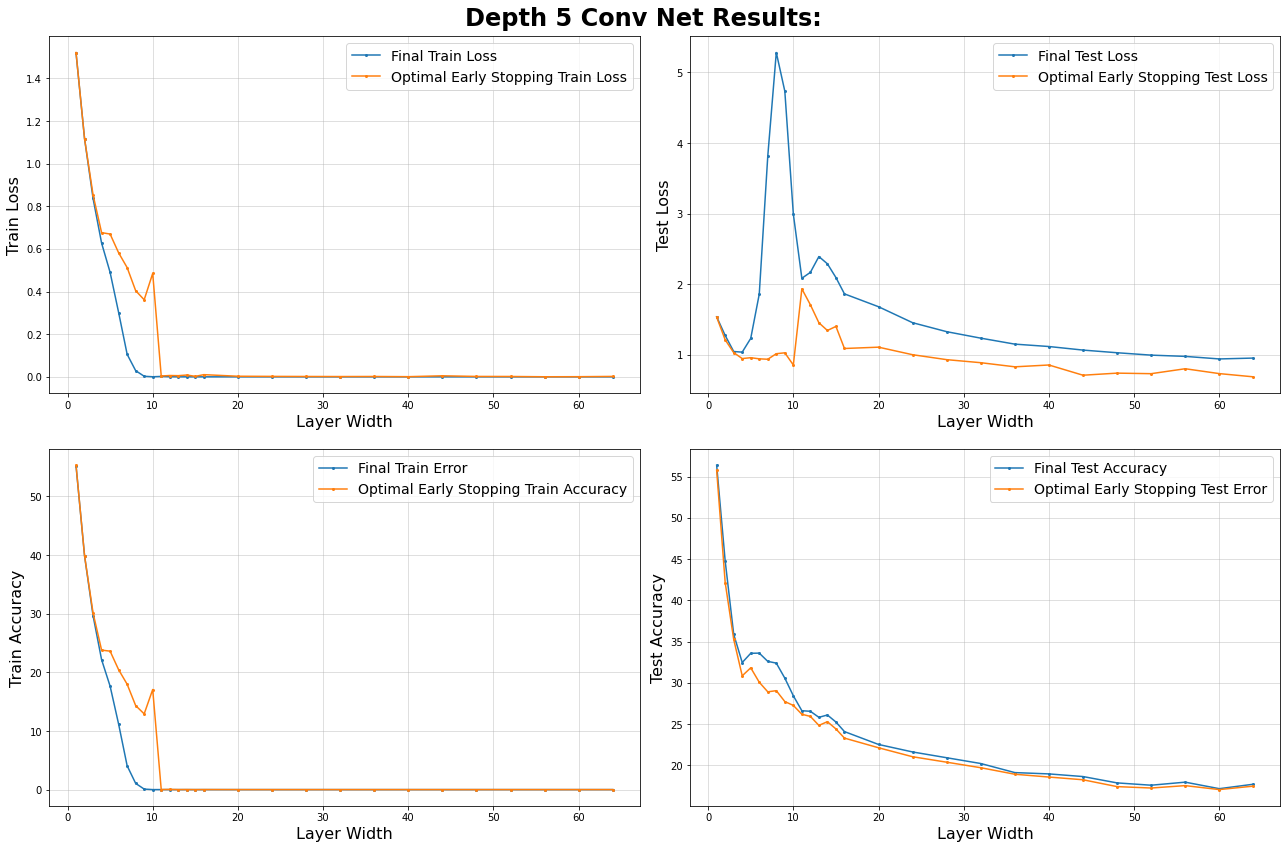

In [ ]:
convnet_depth = 5
plot_path = f'experimental_results/conv_nets_depth_{convnet_depth}_{label_noise_int}pct_noise.pkl'
plot_loss_from_file_convnets(plot_path, depth=convnet_depth)

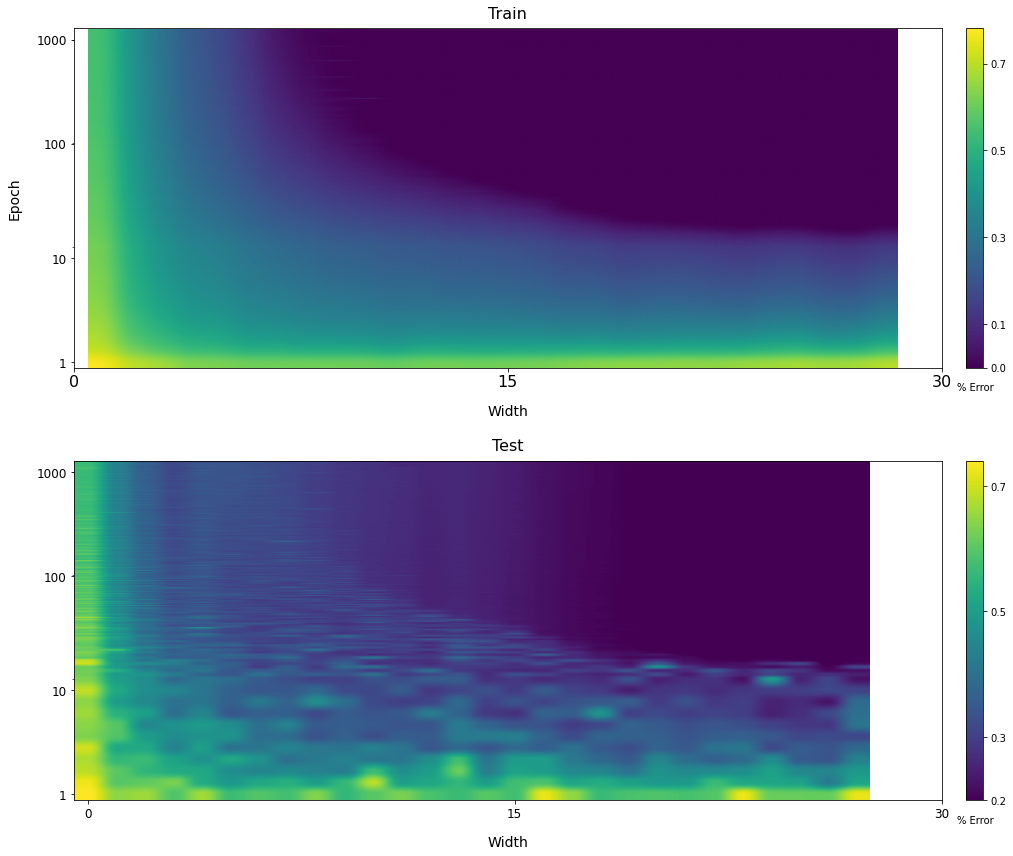

In [ ]:
plot_loss_vs_epoch_from_file_convnets(
    plot_path,
    x_idx=[0, 15, 30], 
    contour_levels=None
)